In [1]:
import pandas as pd
import numpy as np
import math
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from color_helpers import red, purple, blue, get_shade

import warnings
warnings.filterwarnings('ignore')

from data_helpers import roll_signal

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-ikkqcvdk because the default path (/home/ubuntu/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
user_id = 581

# main dataframe, individuals identitfied by "user_id" column, days identified by "date" column
df = pd.read_csv(f'/mnt/results/edema_pred/user_{user_id}_edema_pred_hyperimpute_with_date.csv')

# events dictionary, keys: user_ids, values: event date lists
events = {
    252: [datetime(2021, 7, 10).date(), datetime(2021, 9, 19).date()],
    416: [datetime(2022, 7, 10).date()],

}

# periods dictionary, keys: user_ids, values: period (start_date, end_date) lists
periods = {
    252: [(datetime(2021, 9, 30).date(), datetime(2021, 10, 31).date())]
}
df.columns

Index(['cal_total', 'daily_movement', 'high', 'inactive', 'low', 'medium',
       'non_wear', 'rest', 'steps', 'impedance_mag_1_ohms',
       'impedance_phase_1_degs', 'weight_kg', 'breath_average', 'answer_text',
       'date'],
      dtype='object')

In [3]:
user_id_lst = [user_id] * len(df)
df['user_id'] = user_id_lst
df['date']= pd.to_datetime(df['date'])
# fill in missing dates for each user id
dates_df = df.groupby('user_id').agg(
    start_date=('date', min), end_date=('date', max)
).reset_index()
dates_df['date'] = dates_df.apply(
    lambda x: [x.start_date + timedelta(days=n) for n in range((x.end_date-x.start_date).days+1)], axis=1
)
dates_df = dates_df.explode('date')
dates_df = dates_df[['user_id', 'date']]
df = dates_df.merge(df, on=['user_id', 'date'], how='left')

In [8]:
fields = ['impedance_mag_1_ohms',
       'impedance_phase_1_degs', 'weight_kg', 'breath_average', # 'cal_total', 
       'daily_movement',  'inactive', 'low',
       'medium', 'high', 'non_wear', 'rest', 'steps',  'answer_text',]

labels = {'cal_active':'Active calories',
'cal_total':'Calories',
'daily_movement':'Daily movement',
'high':'Minutes of high-intensity activity',
'inactive':'Minutes of inactive',
'low':'Minutes of low-intensity activity',
'medium':'Minutes of medium-intensity activity',
'met_min_high':'High-intensity MET',
'met_min_inactive':'Inactive MET',
'met_min_low':'Low-intensity MET',
'met_min_medium':'Medium-intensity MET',
'non_wear':'Minutes of non-wear',
'rest':'Minutes of rest',
'steps':'Total daily steps',
'impedance_mag_1_ohms':'Impedance magnitude',
'impedance_phase_1_degs':'Impedance phase',
'weight_kg':'Weight',
'breath_average':'Respiratory rate',
'answer_text':'Edema'}

units = {
    # 'hr_average': '(bpm)',
    # 'rmssd': '(ms)',
    # 'breath_average': '(brpm)',
    # 'temperature_delta': '(°C)',
    # 'duration': '(s)',
    # 'efficiency': '',
    # 'score_disturbances': '',
    # 'score': ''

    'cal_active':'kCal',
    'cal_total':'kCal',
    'daily_movement':'',
    'high':'(min)',
    'inactive':'(min)',
    'low':'(min)',
    'medium':'(min)',
    'met_min_high':'(min)',
    'met_min_inactive':'(min)',
    'met_min_low':'(min)',
    'met_min_medium':'(min)',
    'non_wear':'(min)',
    'rest':'(min)',
    'steps':'',
    'impedance_mag_1_ohms':'',
    'impedance_phase_1_degs':'',
    'weight_kg':'(kg)',
    'breath_average':'(brpm)',
    'answer_text':'',
}



In [9]:
for field in fields:
    df = roll_signal(df, field)

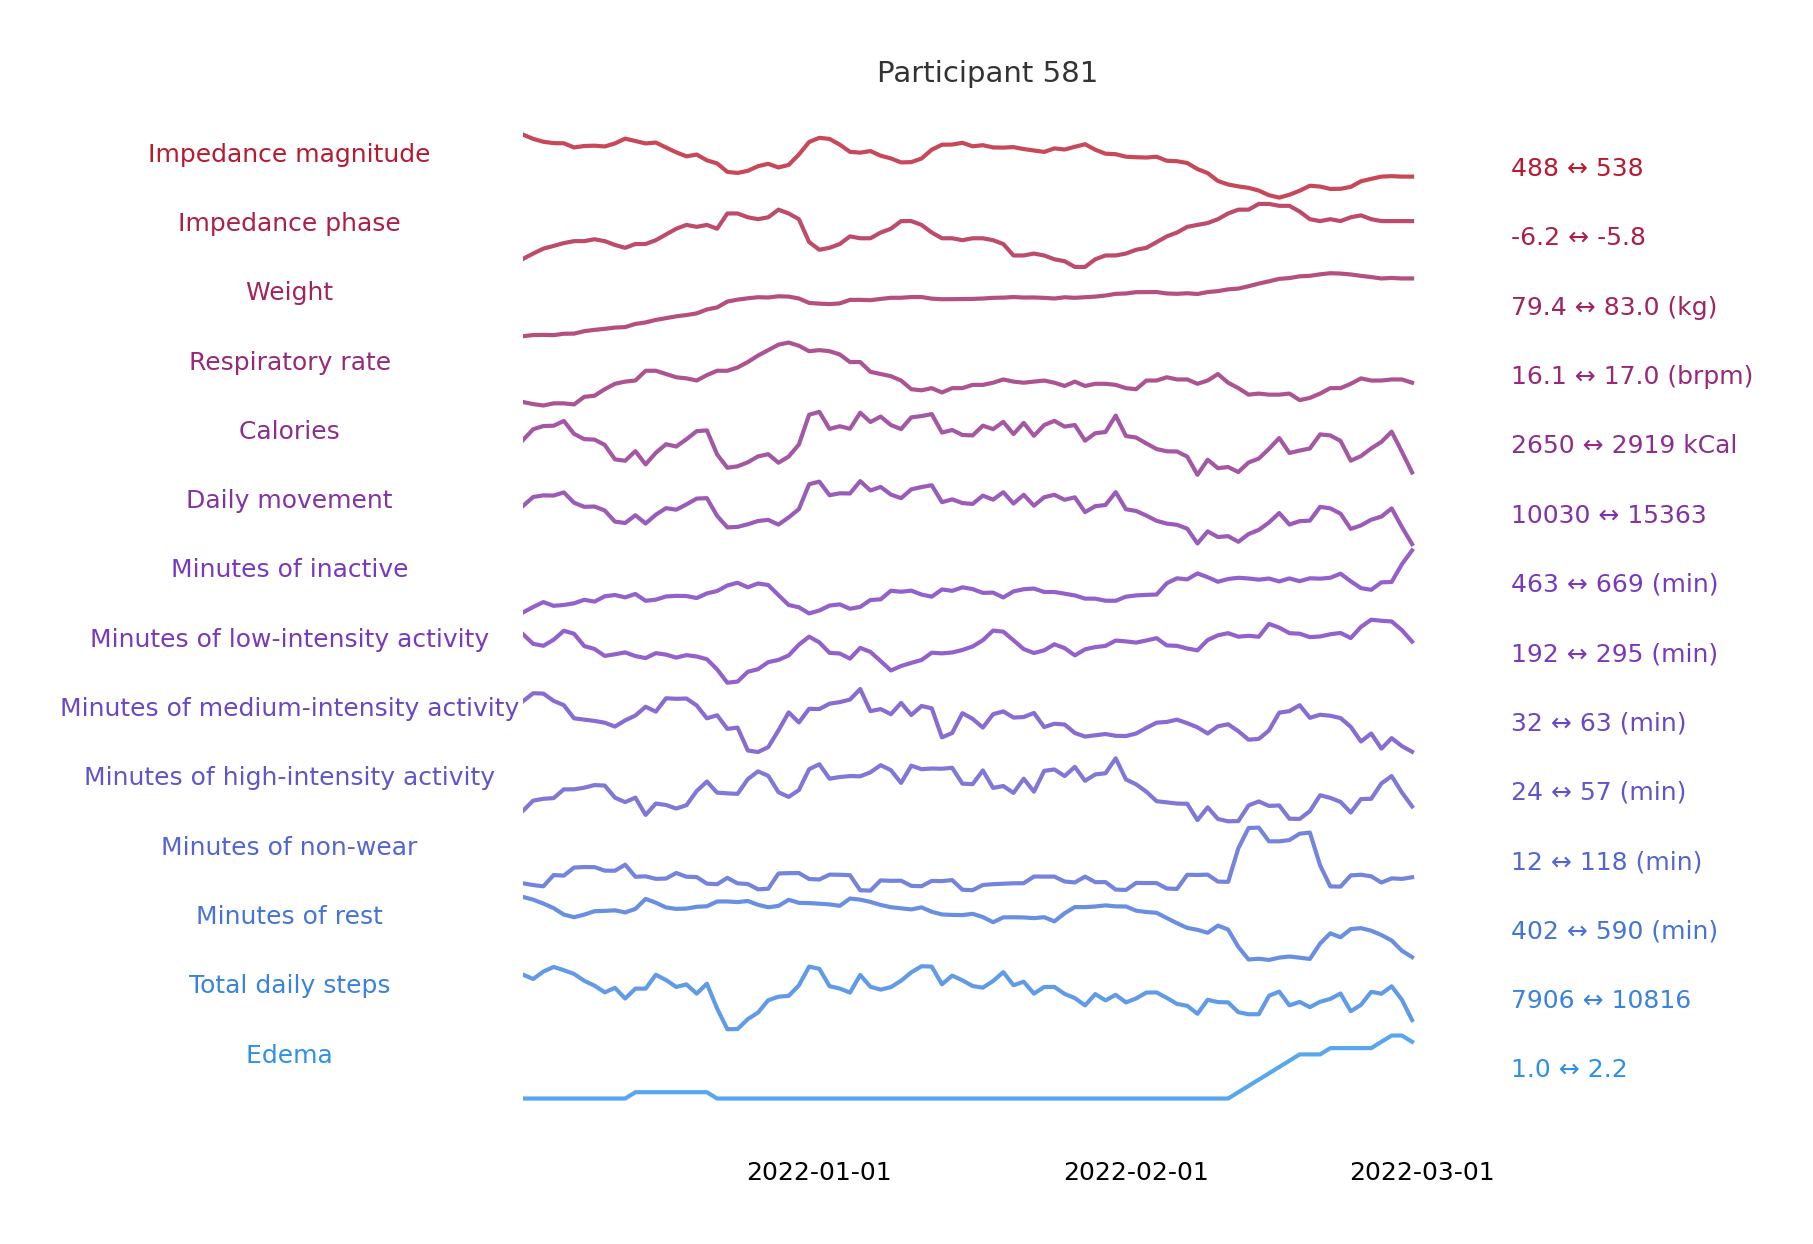

In [6]:
colors = get_shade(red, purple, blue, len(fields))

def remove_frame(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
def custom_round(y, y_range):
    # round y value to level of significance depending on y range
    power_of_10 = math.ceil(math.log10(y_range))
    if power_of_10 > 1:
        return int(y)
    if power_of_10 == 1:
        return round(y, 1)
    return round(y, -power_of_10+1)
    
def plot_trajectory(df, user_id, fields, events=None, periods=None, multiplier=1):
    # pdf = df.loc[df.user_id == user_id].copy()
    pdf = df.copy()
    pdf = pdf.sort_values('date').reset_index(drop=True)
    min_date, max_date = pdf.date.min(), pdf.date.max()
    fig, ax = plt.subplots(len(fields), figsize=(2, multiplier*0.15*len(fields)), dpi=600)

    i = 0
    for field in fields:
        ax[i].yaxis.set_major_locator(MaxNLocator(integer=True))
        color = colors[i]
        ax[i].plot(pdf.date, pdf['rolled_' + field], color=color, linewidth=0.5, alpha=0.8)
        
        if events and user_id in events:
            for event_date in events[user_id]:
                if min_date <= event_date <= max_date:
                    ax[i].axvline(x=event_date, color='black', linewidth=0.25, linestyle=':')
                    
        if periods and user_id in periods:
            for period in periods[user_id]:
                period_start, period_end = period
                period_start = max(min_date, period_start)
                period_end = min(max_date, period_end)
                ax[i].axvspan(period_start, period_end, facecolor='#BBBBBB', alpha=0.22)
                
        ax[i].tick_params(axis='both', which='major', labelsize=3, width=0)

        ax[i].set_ylabel(labels.get(field, field) + ' ' * 50, color=color, size=3, weight='medium', rotation='horizontal')
        ax[i].set_xlim([min_date, max_date])
        
        if i != len(fields)-1:
            ax[i].get_xaxis().set_ticks([])
        for label in ax[i].get_xaxis().get_ticklabels()[::2]:
            label.set_visible(False)
        
        ax[i].yaxis.tick_right()
        y_min, y_max = ax[i].get_ylim()
        y_midpoint = (y_min + y_max)/2
        ax[i].get_yaxis().set_ticks([y_midpoint])
        
        y_min = round(pdf['rolled_' + field].min(), 2)
        y_max = round(pdf['rolled_' + field].max(), 2)
        y_range = y_max - y_min
        y_min = custom_round(y_min, y_range)
        y_max = custom_round(y_max, y_range)
        ax[i].get_yaxis().set_ticklabels([f'{y_min} ↔ {y_max} ' + units[field]], color=color, size=3)
        remove_frame(ax[i])
        if i == 0:
            ax[i].set_title(f'Participant {user_id}', color='#333333', size=3.5)
        
        i += 1
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()


min_date, max_date = df.date.min(), df.date.max()
total_days = (max_date - min_date).days
train_date_end = min_date + timedelta(days=int(0.6*total_days))
val_date_end = min_date + timedelta(days=int(0.8*total_days))
events = {user_id: [train_date_end, val_date_end]}
events = {}
plot_trajectory(df, user_id=user_id, fields=fields, events=events, periods=periods)